In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

## LSun bedroom data

For this lesson, we'll be using the bedrooms from the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom).

In [3]:
path = Config.data_path()/'lsun'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/lsun')

Uncomment the next commands to download and extract the data in your machine.

In [4]:
#! kaggle datasets download -d jhoward/lsun_bedroom -p {path}  

In [5]:
#! unzip -q -n {path}/lsun_bedroom.zip -d {path}
#! unzip -q -n {path}/sample.zip -d {path}

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later.

In [6]:
class NoisyItem(ItemBase):
    def __init__(self, noise_sz): self.obj,self.data = noise_sz,torch.randn(noise_sz, 1, 1)
    def __str__(self):  return ''
    def apply_tfms(self, tfms, **kwargs): return self

In [7]:
class GANItemList(ImageItemList):
    _label_cls = ImageItemList
    
    def __init__(self, items, noise_sz:int=100, **kwargs):
        super().__init__(items, **kwargs)
        self.noise_sz = noise_sz
        self.copy_new.append('noise_sz')
    
    def get(self, i): return NoisyItem(self.noise_sz)
    def reconstruct(self, t): return NoisyItem(t.size(0))
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        super().show_xys(ys, xs, imgsize=imgsize, figsize=figsize, **kwargs)

In [8]:
def get_data(bs, size):
    train_ds = (GANItemList.from_folder(path).label_from_func(noop)
               .transform(tfms=[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], size=size, tfm_y=True))
    return (ImageDataBunch.create(train_ds, valid_ds=None, path=path, bs=bs)
                     .normalize(do_x=False, stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_y=True))

We'll begin with a small side and use gradual resizing.

In [9]:
data = get_data(64, 64)

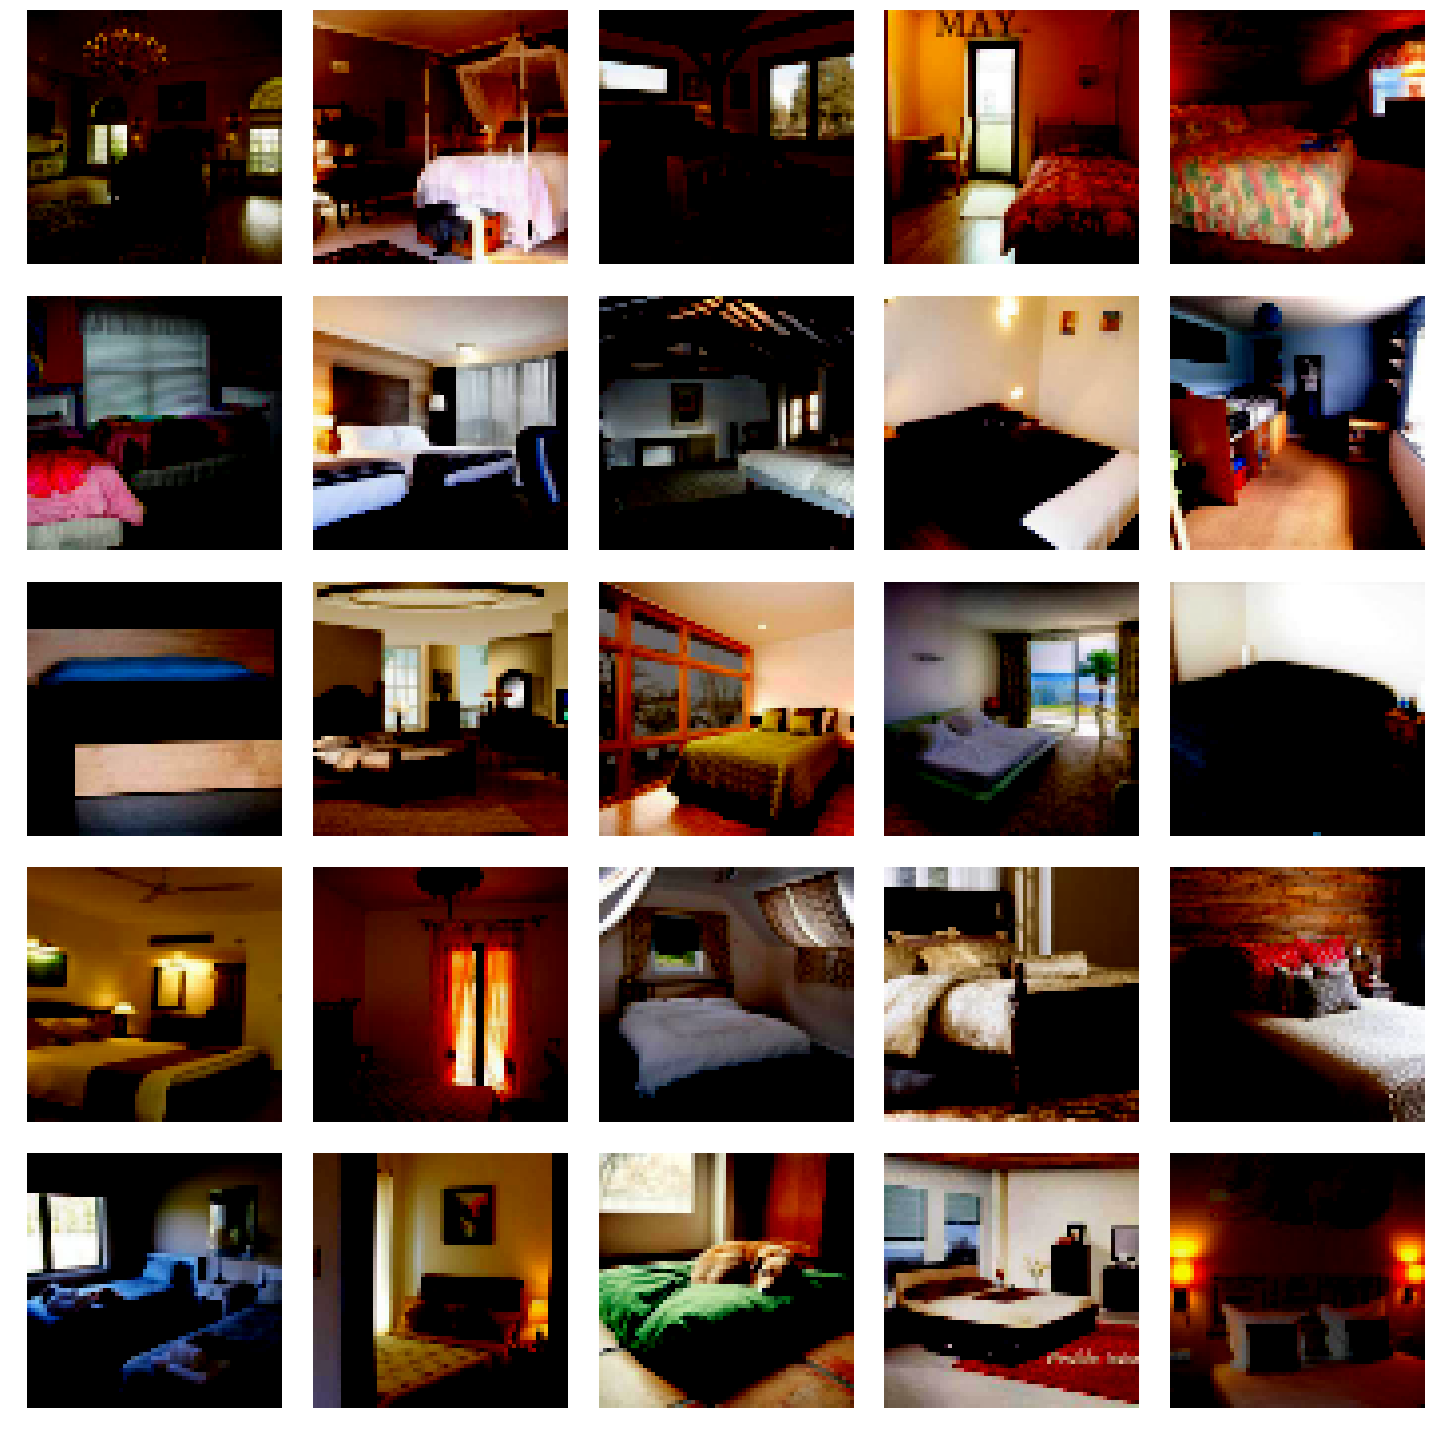

In [10]:
data.show_batch(rows=5)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a discriminator. The generator will try to make new images similar to the ones in our dataset, and the discriminator job will try to classify real images from the ones the generator does. The generator returns images, the discriminator a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the discriminator for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the discriminator evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the discriminator with the gradients of this loss
  
  
2. Freeze the discriminator and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the discriminator on it
  - return a loss that rewards posisitivly the discriminator thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a discriminator that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [11]:
generator = models.basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
discriminator = models.basic_discriminator(in_size=64, n_channels=3, n_extra_layers=1)

In [12]:
class GANModule(nn.Module):
    "Wrapper around a `generator` and a `discriminator` to create a GAN."
    def __init__(self, generator:nn.Module, discriminator:nn.Module, gen_mode:bool=False):
        super().__init__()
        self.gen_mode = gen_mode
        self.generator,self.discriminator = generator,discriminator
    
    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.discriminator(*args)
    
    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in dicriminator mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

In [13]:
class GANLoss(GANModule):
    
    def __init__(self, loss_funcD:Callable, loss_funcG:Callable, gan_model:nn.Module):
        super(GANModule, self).__init__()
        self.loss_funcD,self.loss_funcG,self.gan_model = loss_funcD,loss_funcG,gan_model
        
    def generator(self, output, target):
        fake = self.gan_model.discriminator(output)
        return self.loss_funcG(fake, target)
    
    def discriminator(self, real, input):
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake = self.gan_model.discriminator(fake)
        return self.loss_funcD(real, fake)

In [14]:
@dataclass
class GANTrainer(LearnerCallback):
    "`LearnerCallback` that handles GAN Training."
    _order=-20
    clip:float=0.01
    beta:float=0.98
    gen_mode:bool=False
    
    def _set_trainable(self):
        requires_grad(self.learn.model.generator, self.gen_mode)
        requires_grad(self.learn.model.discriminator, not self.gen_mode)
    
    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and disciminator."
        self.opt_gen = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.generator))])
        self.opt_disc = self.learn.opt.new([nn.Sequential(*flatten_model(self.learn.model.discriminator))])
        self.switch(self.gen_mode)
        self.dlosses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerD = SmoothenValue(self.beta),SmoothenValue(self.beta)
        self.learn.recorder.no_val=True
        self.learn.recorder.add_metric_names(['gen_loss', 'disc_loss'])
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip`."
        if self.clip is not None:
            for p in self.learn.model.discriminator.parameters(): 
                p.data.clamp_(-self.clip, self.clip)
        return (last_input,last_target) if self.gen_mode else (last_target, last_input)
        
    def on_backward_begin(self, last_loss, **kwargs):
        "Record `last_loss` in the proper list."
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss.detach().cpu())
            self.glosses.append(self.smoothenerG.smooth)
        else:
            self.smoothenerD.add_value(last_loss.detach().cpu())
            self.dlosses.append(self.smoothenerD.smooth)
            
    def on_batch_end(self, pbar, last_output, **kwargs):
        if self.gen_mode and len(self.glosses)%10 == 0:
            img = last_output[0].detach().cpu() / 2 + 0.5
            pbar.show_img(Image(img))
    
    def on_epoch_end(self, **kwargs):
        "Put the various losses in the recorder."
        self.learn.recorder.add_metrics([self.smoothenerG.smooth,self.smoothenerD.smooth])
    
    def switch(self, gen_mode:bool=None):
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.learn.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_disc.opt
        self._set_trainable()
        self.learn.model.switch(gen_mode)
        self.learn.loss_func.switch(gen_mode)

In [15]:
@dataclass
class FixedGANSwitcher(LearnerCallback):
    n_disc_iter:Union[int,Callable]
    n_gen_iter:Union[int,Callable]
    
    def on_train_begin(self, **kwargs):
        self.n_d,self.n_g = 0,0
    
    def on_batch_end(self, iteration, **kwargs):
        if self.learn.gan_trainer.gen_mode: 
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen_iter,self.n_d,self.n_g
        else:
            self.n_d += 1
            n_iter,n_in,n_out = self.n_disc_iter,self.n_g,self.n_d
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out: 
            self.learn.gan_trainer.switch()
            self.n_d,self.n_g = 0,0

In [16]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and iniialize `nn.Conv1d` layer."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

In [17]:
class SelfAttention(nn.Module):
    "Self attention layer for 2d."
    def __init__(self, n_channels:int):
        super().__init__()
        self.query = conv1d(n_channels, n_channels//8)
        self.key   = conv1d(n_channels, n_channels//8)
        self.value = conv1d(n_channels, n_channels)
        self.gamma = nn.Parameter(tensor([0.]))
        
    def forward(self, x):
        #Notations from https://arxiv.org/pdf/1805.08318.pdf
        size = x.size()
        x = x.view(*size[:2],-1)
        f,g,h = self.query(x),self.key(x),self.value(x)
        beta = F.softmax(torch.bmm(f.permute(0,2,1).contiguous(), g), dim=1)
        o = self.gamma * torch.bmm(h, beta) + x
        return o.view(*size).contiguous()

In [20]:
generator = models.basic_generator(in_size=64, n_channels=3, n_extra_layers=1, self_attention=True)
discriminator = models.basic_discriminator(in_size=64, n_channels=3, n_extra_layers=1, self_attention=True)

In [21]:
gan = GANModule(generator, discriminator)
loss_func = GANLoss(WassersteinLoss(), NoopLoss(), gan)
learn = Learner(data, gan, loss_func=loss_func, opt_func=optim.RMSprop, wd=0., 
                callback_fns=[GANTrainer, partial(FixedGANSwitcher, n_disc_iter=5,n_gen_iter=1)])

In [22]:
learn.fit(1,1e-4)

epoch,train_loss,gen_loss,disc_loss


AttributeError: 'NBMasterBar' object has no attribute 'show_img'

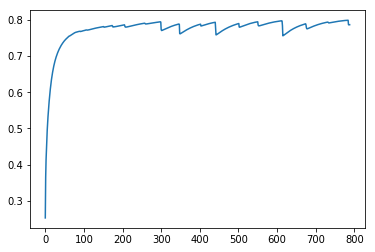

In [26]:
plt.plot(learn.gan_trainer.glosses)

In [ ]:
x,y = next(iter(data.train_dl))

In [109]:
learn.gan_trainer.switch(gen_mode=True)

In [121]:
z = learn.model(x.clone())
loss = loss_func(z,y.clone())
loss

tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward1>)

In [122]:
generator.zero_grad()

In [123]:
loss.backward()

In [129]:
grad1 = one_param(learn.model.generator).grad

In [125]:
generator.zero_grad()

In [126]:
fake = generator(x.clone())
pred = discriminator(fake)
loss1 = NoopLoss()(pred, y.clone())

In [127]:
loss1.backward()

In [130]:
grad2 = one_param(learn.model.generator).grad

In [131]:
(grad1-grad2).abs().mean()

tensor(0., device='cuda:0')

In [162]:
def old_get_data(bs, size):
    train_ds = (ImageItemList.from_folder(path).label_empty()
               .transform(tfms=[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))],size=size))
    return (ImageDataBunch.create(train_ds, valid_ds=None, path=path, bs=bs)
                     .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])]))

In [163]:
data1 = old_get_data(64,64)

In [169]:
x,y = next(iter(data1.train_dl))

In [170]:
x.mean(0).mean(1).mean(1), x.std(0).std(1).std(1)

(tensor([ 0.1863,  0.0730, -0.0390], device='cuda:0'),
 tensor([0.0075, 0.0062, 0.0054], device='cuda:0'))

In [168]:
x.mean(0).mean(1).mean(1), x.std(0).std(1).std(1)

(tensor([ 0.2012,  0.0914, -0.0215], device='cuda:0'),
 tensor([0.0054, 0.0055, 0.0055], device='cuda:0'))

In [184]:
x,y = next(iter(data.train_dl))

In [185]:
y.mean(0).mean(1).mean(1), y.std(0).std(1).std(1)

(tensor([ 0.1734,  0.0818, -0.0214], device='cuda:0'),
 tensor([0.0050, 0.0053, 0.0060], device='cuda:0'))

In [37]:
learn.fit(1, 1e-4)

epoch,train_loss,gen_loss,disc_loss


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._

KeyboardInterrupt: 

In [20]:
learn.gan_trainer.opt_gen

OptimWrapper over RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0
    weight_decay: 0
).
True weight decay: True

### Tests

In [12]:
learn.fit(10, 2e-4)

epoch,train_loss,gen_loss,disc_loss
1,-0.517198,0.557713,-1.056202
2,-0.567331,0.567330,-1.151070
3,-0.404719,0.475858,-0.833572
4,-0.388531,0.432477,-0.793346
5,-0.356051,0.409827,-0.746511
6,-0.337314,0.366393,-0.693313
7,-0.291445,0.318001,-0.595872
8,-0.255594,0.283075,-0.540518
9,-0.249409,0.261784,-0.510216
10,-0.228337,0.242933,-0.469531


In [15]:
learn.save('stage1')

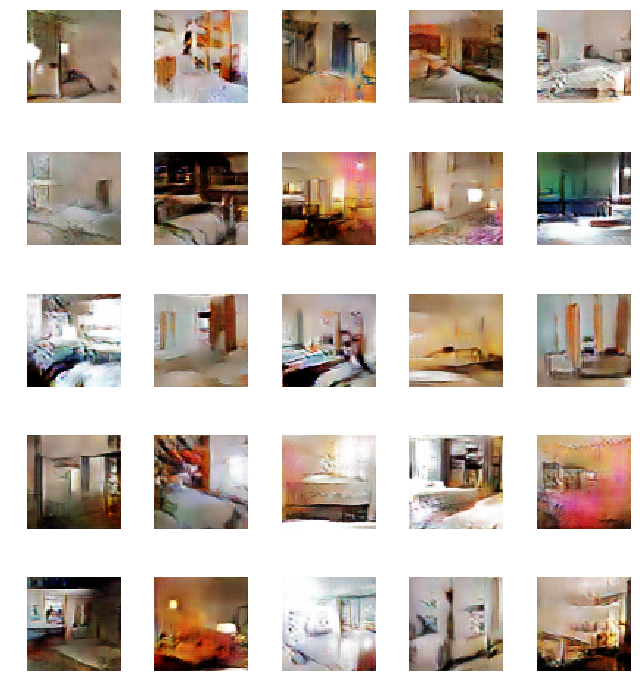

In [14]:
learn.show_results(rows=5)